# Geophysical tutorial: Step-by-step NMO correction

by [Leonardo Uieda](http://www.leouieda.com)

*This is a part of The Leading Edge [tutorials
series](https://dx.doi.org/10.1190/tle35020190.1).*

Open any text book about seismic data processing and you will inevitably find a
section about the Normal Moveout (NMO) correction.
When applied to a Common Mid Point (CMP) section, the correction is supposed to
turn the hyperbola associated with a reflection into a straight horizontal
line.
What most text books won't tell you is *how, exactly, do you apply this
equation to the data*?

That is what this tutorial will teach you (hopefully).

**Note**: This notebook is based on the material for my NMO and velocity analysis lecture of my [Intro Geophysics II](https://github.com/leouieda/geofisica2) course (in Portuguese).

## Running the code in this notebook

This is a [Jupyter notebook](http://jupyter.org/). It is divided into blocks called *cells*. Each cell can contain text formated in Markdown (like this one! click on it to see) or Python source code. Cells can be run individually by clicking on it and pressing `Shift+Enter`. Note that variables created in a cell are global to the notebook, they are not bound to a specific cell. Running Markdown cells will render the text nicely.

## Libraries

First, we need to load the libraries that make life so pleasant in Python-land.

In [1]:
%matplotlib inline
import numpy as np                         # For array based computations and world domination
from scipy.interpolate import CubicSpline  # For  interpolation functions
import matplotlib.pyplot as plt            # For making plots

We'll use the `seaborn` plot style because it's nicer and more modern than the default. Plus, it doesn't look so much like Matlab.

In [2]:
plt.style.use(['seaborn-dark', 'seaborn-colorblind', 'seaborn-notebook'])

## Loading a synthetic CMP

We'll use a synthetic CMP gather to test our NMO correction. I prepared this data set using a finite-difference acoustic wave propagation code that is currently under development for the [Fatiando a Terra](http://jupyter.org/) library (see [pull request 308](https://github.com/fatiando/fatiando/pull/308)).

The data are stored in a [compressed numpy format](https://docs.scipy.org/doc/numpy/reference/generated/numpy.savez_compressed.html) and can be loaded with `numpy.load`.

In [3]:
data = np.load('data/synthetic_cmp.npz')
print("Data in the archive:", data.keys())

Data in the archive: ['dt', 'offsets', 'CMP']


In [4]:
dt = data['dt']
offsets = data['offsets']
cmp = data['CMP']
nsamples = cmp.shape[0]
noffsets = cmp.shape[1]
print('dt = {} s'.format(dt))
print('offsets =', offsets)
print('N samples = {}'.format(nsamples))
print('N offsets = {}'.format(noffsets))

dt = 0.00045678391959799 s
offsets = [120 180 240 300 360 420 480 540 600 660 720 780 840 900]
N samples = 1200
N offsets = 14


Let's visualize our CMP gather using matplotlib.

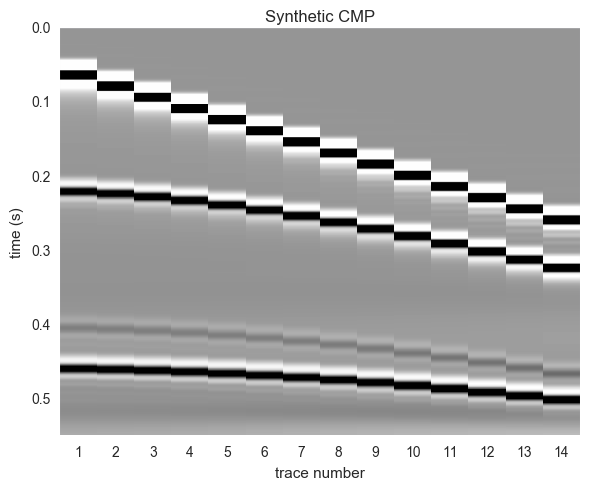

In [5]:
fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111)
ax.set_title('Synthetic CMP')
ax.set_xlabel('trace number')
ax.set_ylabel('time (s)')
cutoff = 0.1
ax.imshow(cmp, extent=[0.5, noffsets + 0.5, dt*nsamples, 0], 
          aspect=20, cmap='Greys', vmin=-cutoff, vmax=cutoff, 
          interpolation='none')
trace_numbers = list(range(1, noffsets + 1))
ax.set_xticks(trace_numbers)
fig.tight_layout()

The events that we can see in the CMP are (from top to bottom):
1. The direct wave.
2. The reflection on the first interface.
3. A multiple reflection on the first interface.
4. The reflection on the second interface.

## Building our NMO correction

The algorithm for NMO correction described in the tutorial is:

1. Start with an NMO gather filled with zeros.
2. For each point ($t_0, x$) in the NMO gather, do:

    * Calculate the reflection travel-time ($t$) given $v_{NMO}$.
    * Go to the trace at offset $x$ in the CMP and find the two samples before and the two samples after time $t$.
    * If $t$ is greater than the recording time or if it doesn't have two samples after it, skip the next two steps.
    * Use the amplitude in these four samples to interpolate the amplitude at time $t$.
    * Copy the interpolated amplitude to the NMO gather at ($t_0, x$).
    
We'll use three functions to implement this whole algorithm. The advantages of breaking up a complex task into blocks are many:

* We can test each section independently of the whole.
* Smaller functions are easier to understand and get right.
* Small functions can be reused later.
* It allows us to focus on the whole algorithm first and shove the details into functions.

First, let's start with a function that performs the overall correction, relying on some functions that we'll define later on. This should look very similar to our algorithm above. We'll leave the details of calculating $t$ and interpolating the amplitude for later.

In [6]:
def nmo_correction(cmp, dt, offsets, velocities):
    """
    Performs NMO correction on the given CMP.
    
    The units must be consistent. E.g., if dt is seconds and
    offsets is meters, velocities must be m/s.
    
    Parameters
    ----------
    
    cmp : 2D array
        The CMP gather that we want to correct.
    dt : float
        The sampling interval.
    offsets : 1D array
        An array with the offset of each trace in the CMP.
    velocities : 1D array
        An array with the NMO velocity for each time. Should
        have the same number of elements as the CMP has samples.
        
    Returns
    -------
    
    nmo : 2D array
        The NMO corrected gather.
        
    """
    nmo = np.zeros_like(cmp)
    nsamples = cmp.shape[0]
    times = np.arange(0, nsamples*dt, dt)
    for i, t0 in enumerate(times):
        for j, x in enumerate(offsets):
            t = reflection_time(t0, x, velocities[i])
            amplitude = sample_trace(cmp[:, j], t, dt)
            # If the time t is outside of the CMP time range,
            # amplitude will be None.
            if amplitude is not None:
                nmo[i, j] = amplitude
    return nmo    

Now we can implement the details. First, calculating the reflection times:

$$ t = \sqrt{ t_0^2 + \dfrac{x^2}{v_{NMO}^2} } $$

In [7]:
def reflection_time(t0, offset, velocity):
    """
    Calculate the travel-time of a reflected wave.
    
    Doesn't consider refractions or changes in velocity.
        
    The units must be consistent. E.g., if t0 is seconds and
    offset is meters, velocity must be m/s.
    
    Parameters
    ----------
    
    t0 : float
        The 0-offset (normal incidence) travel-time.
    offset : float
        The offset of the receiver.
    velocity : float
        The velocity of the wave.
        
    Returns
    -------
    
    t : float
        The reflection travel-time.
        
    """
    t = np.sqrt(t0**2 + offset**2/velocity**2)
    return t

We should test that this function works. One way to do so is to use simple cases. For example, if `offset=0` then `t == t0`:

In [8]:
assert reflection_time(t0=4, offset=0, velocity=1000) == 4, "Failed test."

If nothing happens, that means our test passed. We can also test this visually and check that the result is indeed a hyperbola. We'll plot it on top of the CMP. I know that the true velocity of the first layer is 4000 m/s and from the CMP it seems that $t_0$ is about 0.2 s.

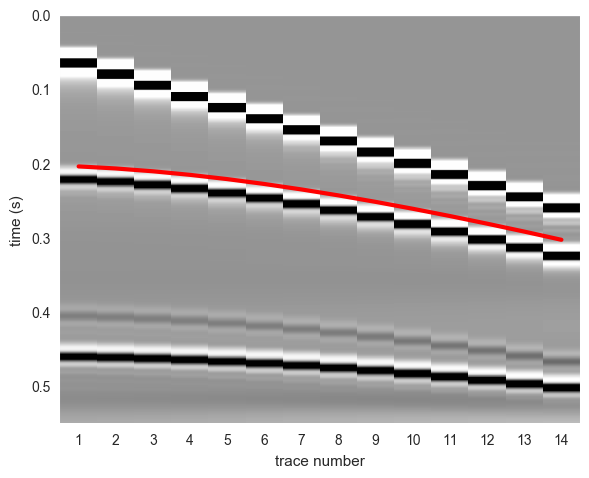

In [9]:
reflect_times = reflection_time(t0=0.2, offset=offsets, velocity=4000)

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111)
ax.set_xlabel('trace number')
ax.set_ylabel('time (s)')
cutoff = 0.1
ax.imshow(cmp, extent=[0.5, noffsets + 0.5, dt*nsamples, 0], 
          aspect=20, cmap='Greys', vmin=-cutoff, vmax=cutoff, 
          interpolation='none')
trace_numbers = list(range(1, noffsets + 1))
plt.plot(trace_numbers, reflect_times, '-r', linewidth=3)
ax.set_xticks(trace_numbers)
ax.set_ylim(nsamples*dt, 0)
ax.set_xlim(0.5, noffsets + 0.5)
fig.tight_layout()

Looks reasonable.

The last part is the trickiest: finding and interpolating the amplitude value from the CMP.

In [10]:
def sample_trace(trace, time, dt):
    """
    Sample an amplitude at a given time using interpolation.
    
    Parameters
    ----------
    
    trace : 1D array
        Array containing the amplitudes of a single trace.
    time : float
        The time at which I want to sample the amplitude.
    dt : float
        The sampling interval
        
    Returns
    -------
    
    amplitude : float or None
        The interpolated amplitude. Will be None if *time*
        is beyond the end of the trace or if there are less
        than 2 points between *time* and the end.
        
    """
    # The floor function will give us the integer
    # right behind a given float.
    # Use it to get the sample number that is right
    # before our desired time.
    before = int(np.floor(time/dt))
    nsamples = trace.size
    # Use the 4 samples around time to interpolate
    samples = np.arange(before - 1, before + 3, 1)
    if np.any(samples < 0) or np.any(samples >= nsamples):
        amplitude = None
    else:
        times = dt*samples
        amps = trace[samples]
        interpolator = CubicSpline(times, amps)
        amplitude = interpolator(time)
    return amplitude

Let's test this function on a trace of our CMP. If we ask for a sample at a time that was actually measured, we should get back the correct amplitude.

In [11]:
trace = cmp[:, 0]

In [12]:
for sample in range(2, trace.size - 2):
    interpolated = sample_trace(trace, sample*dt, dt)
    assert np.allclose(trace[sample], interpolated)

Again, no errors means that our test passes. Another case we should test is if the function returns `None` when asked for a sample too close to time 0 or the end of the trace.

In [13]:
for sample in [0, trace.size - 2, trace.size - 1]:
    assert sample_trace(trace, sample*dt + 1e-5, dt) is None

## Applying NMO correction

Now that we are certain that both of our inner functions work, let's apply the `nmo_correction` to the CMP and see if the results are correct.

We'll first choose a velocity profile. I'll cheat and use the velocities I know will work. For this example, I'll choose velocities for two points and draw a line between them (thanks [Evan](https://twitter.com/evanbianco) and [Gregorio](https://br.linkedin.com/in/gregorio-kawakami-b8660a14) for suggesting this).

In [14]:
times = np.arange(nsamples)*dt
v1, t1 = 3800, 0.22
v2, t2 = 4500, 0.46
# equation for a straight line between two points.
v_nmo = v1 + ((v2 - v1)/(t2 - t1))*(times - t1)

Now we can use our `nmo_correction` function on the synthetic CMP.

In [15]:
nmo = nmo_correction(cmp, dt, offsets, v_nmo)

Let's make a nice figure for the paper with out CMP, the NMO corrected gather, and the velocity profile.

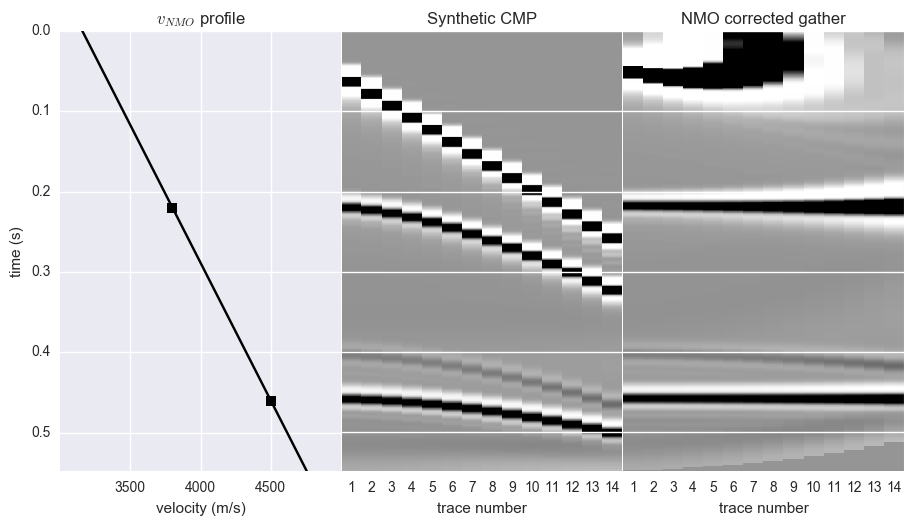

In [16]:
fig = plt.figure(figsize=(9, 5.1))

ax = plt.subplot(131)
ax.set_title(r'$v_{NMO}$ profile')
ax.plot(v_nmo, np.arange(nsamples)*dt, '-k')
ax.plot([v1, v2], [t1, t2], 'sk')
ax.set_xlabel('velocity (m/s)')
ax.set_ylabel('time (s)')
ax.set_xlim(3000, 5000)
ax.set_ylim(nsamples*dt, 0)
ax.grid()
ax.set_xticks(ax.get_xticks()[1:-1])

ax = plt.subplot(132)
ax.set_title('Synthetic CMP')
ax.set_xlabel('trace number')
cutoff = 0.1
aspect = 40
ax.imshow(cmp, extent=[0.5, noffsets + 0.5, dt*nsamples, 0], 
          aspect=aspect, cmap='Greys', vmin=-cutoff, vmax=cutoff, 
          interpolation='none')
trace_numbers = list(range(1, noffsets + 1))
ax.set_xticks(trace_numbers)
ax.set_yticklabels([])
ax.grid(axis='y')

ax = plt.subplot(133)
ax.set_title('NMO corrected gather')
ax.set_xlabel('trace number')
ax.imshow(nmo, extent=[0.5, noffsets + 0.5, dt*nsamples, 0], 
          aspect=aspect, cmap='Greys', vmin=-cutoff, vmax=cutoff, 
          interpolation='none')
trace_numbers = list(range(1, noffsets + 1))
ax.set_xticks(trace_numbers)
ax.set_yticklabels([])
ax.grid(axis='y')

plt.tight_layout(pad=0.2, w_pad=0)
plt.savefig('figures/nmo-application/nmo-application.png', dpi=600)

Nice! The velocities we used make the reflectors flat, which indicates that the algorithm is working. You can even see the distinctive NMO stretch, particularly on the first reflector.

## Make a nice figure to show the sampling algorithm

Finally, let's make a figure to show how we get a sample for the NMO using interpolation.

In [17]:
from matplotlib.patches import ConnectionPatch

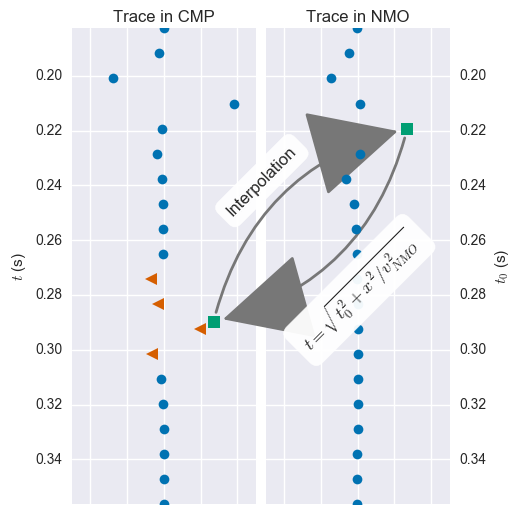

In [18]:
fig = plt.figure(figsize=(5, 5), dpi=1200)

times = np.arange(400, 800, 20)*dt
trace = 10
cmp_trace = cmp[400:800:20, trace]
nmo_trace = nmo[400:800:20, trace]
t0 = times[4]
t = reflection_time(t0, offsets[trace], velocity=3800)
amp_cmp = sample_trace(cmp[:, trace], t, dt)
amp_nmo = nmo_trace[4]
samples = np.array([False]*times.size)
samples[[10, 11, 12, 13]] = True

ax1 = plt.subplot(121)
ax1.set_title('Trace in CMP')
ax1.set_xticklabels([])
ax1.set_ylabel(r'$t$ (s)')
ax1.grid()
ax1.set_ylim(times.max(), times.min())
ax1.set_xlim(-0.5, 0.5)
ax1.plot(cmp_trace[~samples], times[~samples], 'o')
ax1.plot(amp_cmp, t, 's', markersize=9)
ax1.plot(cmp_trace[samples], times[samples], '<', markersize=8)

ax2 = plt.subplot(122)
ax2.set_title('Trace in NMO')
ax2.set_xticklabels([])
ax2.set_ylabel(r'$t_0$ (s)')
ax2.grid()
ax2.set_ylim(times.max(), times.min())
ax2.set_xlim(-0.5, 0.5)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.plot(nmo_trace, times, 'o')
ax2.plot(amp_nmo, t0, 's', markersize=9)

# Add the arrows
arrow_to_cmp = ConnectionPatch(
    [amp_nmo, t0], [amp_cmp, t], 
    coordsA='data', coordsB='data',
    axesA=ax2, axesB=ax1,
    arrowstyle="-|>", shrinkA=7, shrinkB=7,
    mutation_scale=200, fc="#777777",
    linewidth=2, color='#777777',
    connectionstyle='Arc3, rad=-0.3')
ax2.add_artist(arrow_to_cmp)
arrow_to_nmo = ConnectionPatch(
    [amp_nmo, t0], [amp_cmp, t], 
    coordsA='data', coordsB='data',
    axesA=ax2, axesB=ax1,
    arrowstyle="<|-", shrinkA=7, shrinkB=7,
    mutation_scale=200, fc="#777777",
    linewidth=2, color='#777777',
connectionstyle='Arc3, rad=0.3')
ax2.add_artist(arrow_to_nmo)

# Add the text and equation
ax2.text(-0.02, 0.68, 'Interpolation',
         horizontalalignment='center', verticalalignment='center',
         rotation=45, transform=ax2.transAxes, fontsize=12,
         bbox=dict(pad=0.5, edgecolor="white", facecolor='white', alpha=0.95, boxstyle="round"),)

ax2.text(0.51, 0.45, r'$t = \sqrt{ t_0^2 + {x^2} / {v_{NMO}^2} }$',
         horizontalalignment='center', verticalalignment='center',
         rotation=45, transform=ax2.transAxes, fontsize=13,
         bbox=dict(pad=0.5, edgecolor="white", facecolor='white', alpha=0.95, boxstyle="round"),)

plt.tight_layout(pad=0.2, w_pad=0.7)
plt.savefig('figures/sketch-interpolation/sketch-interpolation.png', dpi=1200)

**Note**: the arrows look huge because for some reason matplotlib shrinks them when saving at a higher dpi. So I made them huge to have them the correct size in the saved figure. This is what it looks like in the saved file.

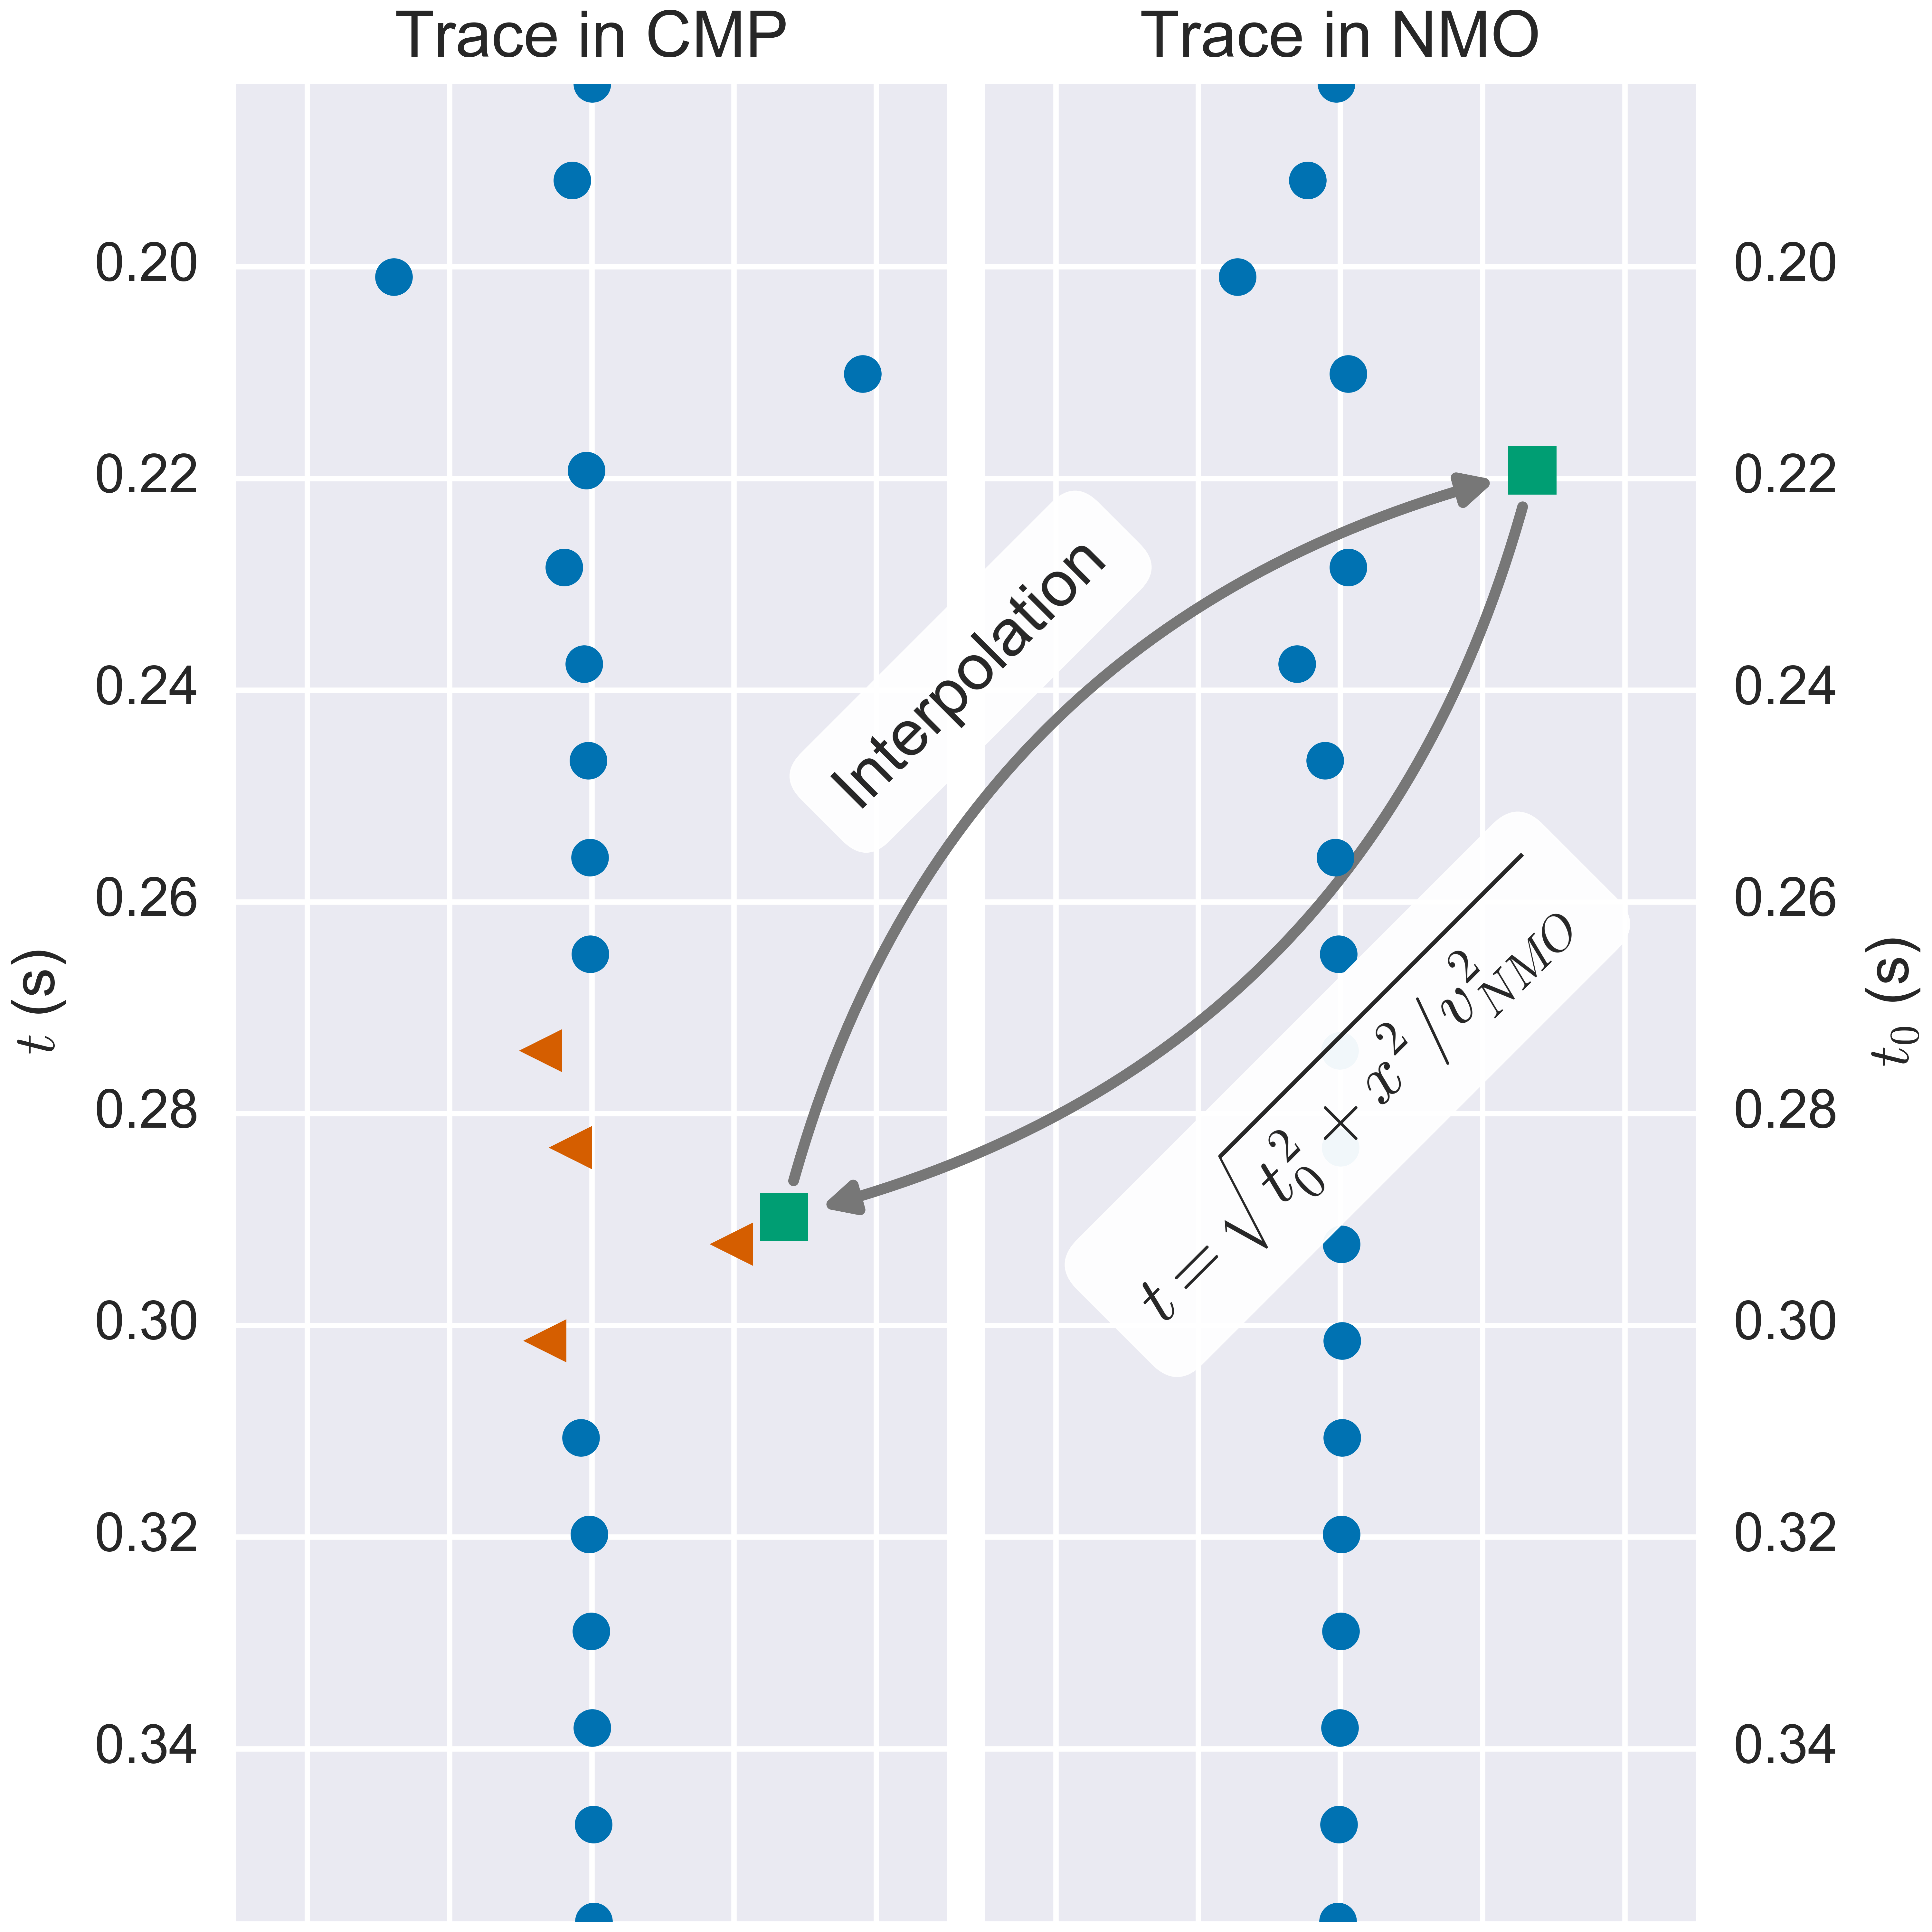

In [19]:
from IPython.display import Image
Image(filename="figures/sketch-interpolation/sketch-interpolation.png")

[]()